In [62]:
import requests
import time
import pandas as pd
import numpy as np
import sqlalchemy

In [63]:
# client-identifier ist Voraussetzung für die Nutzung der Daten
client_header = "testuser-exercise"

headers = {
    "Client-Identifier": client_header
}

# BASE URL
URL = "https://gbfs.urbansharing.com/oslobysykkel.no/"

# endpoints
# Auto-discovery file that links to all of the other files published by the system.
auto = "gbfs.json"

# Machine readable basic information about Oslo City Bike
system = "system_information.json"

# Information about all stations, including geolocation, addresses and descriptions
stations = "station_information.json"

# Bike and dock availability
availability = "station_status.json"




In [64]:
# Überblick verschaffen
response = requests.get(URL + auto, headers = headers)


if response.status_code == 200:
    data = response.json()
    print("Systemname:", data["data"])

else: 
    print("Fehler beim abrufen der Daten:", response.status_code)

Systemname: {'nb': {'feeds': [{'name': 'system_information', 'url': 'https://gbfs.urbansharing.com/oslobysykkel.no/system_information.json'}, {'name': 'vehicle_types', 'url': 'https://gbfs.urbansharing.com/oslobysykkel.no/vehicle_types.json'}, {'name': 'system_pricing_plans', 'url': 'https://gbfs.urbansharing.com/oslobysykkel.no/system_pricing_plans.json'}, {'name': 'station_information', 'url': 'https://gbfs.urbansharing.com/oslobysykkel.no/station_information.json'}, {'name': 'station_status', 'url': 'https://gbfs.urbansharing.com/oslobysykkel.no/station_status.json'}]}}


In [65]:
station_info = requests.get(URL + stations, headers = headers).json()
station_status = requests.get(URL + availability, headers = headers).json()



df_stations = pd.DataFrame(station_info["data"]["stations"])
df_status = pd.DataFrame(station_status["data"]["stations"])

In [66]:
df_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   station_id               270 non-null    object
 1   is_installed             270 non-null    bool  
 2   is_renting               270 non-null    bool  
 3   is_returning             270 non-null    bool  
 4   last_reported            270 non-null    int64 
 5   num_vehicles_available   270 non-null    int64 
 6   num_bikes_available      270 non-null    int64 
 7   num_docks_available      270 non-null    int64 
 8   vehicle_types_available  270 non-null    object
dtypes: bool(3), int64(4), object(2)
memory usage: 13.6+ KB


In [67]:
df_status['station_id'].nunique()

270

In [68]:
df_status['vehicle_types_available'][0]

[{'vehicle_type_id': 'bike', 'count': 2},
 {'vehicle_type_id': 'ebike', 'count': 0}]

In [69]:
df_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          270 non-null    object 
 1   name                270 non-null    object 
 2   address             270 non-null    object 
 3   cross_street        270 non-null    object 
 4   lat                 270 non-null    float64
 5   lon                 270 non-null    float64
 6   is_virtual_station  270 non-null    bool   
 7   capacity            270 non-null    int64  
 8   station_area        270 non-null    object 
 9   rental_uris         270 non-null    object 
dtypes: bool(1), float64(2), int64(1), object(6)
memory usage: 19.4+ KB


In [70]:
#conversion int64 to datetime
df_status["last_reported_dt"] = pd.to_datetime(df_status["last_reported"], unit="s")

In [71]:
df_status

,station_id,is_installed,is_renting,is_returning,last_reported,num_vehicles_available,num_bikes_available,num_docks_available,vehicle_types_available,last_reported_dt
0,5431,True,True,True,1749111367,2,2,19,"[{'vehicle_type_id': 'bike', 'count': 2}, {'ve...",2025-06-05 08:16:07
1,5424,True,True,True,1749111367,0,0,18,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07
2,5220,True,True,True,1749111367,0,0,20,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07
3,5217,True,True,True,1749111367,29,29,1,"[{'vehicle_type_id': 'bike', 'count': 29}, {'v...",2025-06-05 08:16:07
4,5113,True,True,True,1749111367,0,0,15,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07
...,...,...,...,...,...,...,...,...,...,...
265,377,True,True,True,1749111367,9,9,19,"[{'vehicle_type_id': 'bike', 'count': 7}, {'ve...",2025-06-05 08:16:07
266,738,True,True,True,1749111367,1,1,11,"[{'vehicle_type_id': 'bike', 'count': 1}, {'ve...",2025-06-05 08:16:07
267,460,True,True,True,1749111367,0,0,29,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07
268,744,True,True,True,1749111367,0,0,10,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07


In [72]:
#extract count information for every time and every vehicle type
def extract_counts(vehicle_list):
    result = {}
    for d in vehicle_list:
        if isinstance(d, dict):
            result[d["vehicle_type_id"]] = d["count"]
    return result

# Apply the function to each row and convert to DataFrame
df_counts = df_status["vehicle_types_available"].apply(extract_counts).apply(pd.Series)

# Die neue DataFrame an das Original anhängen (optional)
df_status = pd.concat([df_status, df_counts], axis=1)



In [73]:
df_columns_to_keep_status =["station_id","is_installed","is_renting","is_returning","num_docks_available"]
df_status_kept = df_status[df_columns_to_keep_status]


In [74]:
df_stations.describe()
#wir haben Idee über die Capacity wie sie ist 
#was kann man noch interpretieren

,lat,lon,capacity
count,270.000000,270.000000,270.000000
mean,59.922300,10.743617,22.059259
std,0.011292,0.028953,8.800780
min,59.898440,10.651118,6.000000
25%,59.913274,10.726204,15.000000
50%,59.920478,10.746645,21.000000
75%,59.929326,10.762070,27.000000
max,59.953411,10.814314,50.000000


In [75]:
df_status.describe()
#zwischen num_vehicles_available und num_docks sieht man dass niemals waren alles docks verbraucht 
#ich vermute es gibt ein Fehler num_vehicles_available und num_bikes_available warum es ist Überall gleich merkwürdig
# es ist doch capacity = num_docks + bikes_available

,last_reported,num_vehicles_available,num_bikes_available,num_docks_available,last_reported_dt,bike,ebike
count,2.700000e+02,270.000000,270.000000,270.000000,270,270.00000,270.000000
mean,1.749111e+09,6.751852,6.751852,14.922222,2025-06-05 08:16:07,6.12963,0.622222
min,1.749111e+09,0.000000,0.000000,0.000000,2025-06-05 08:16:07,0.00000,0.000000
25%,1.749111e+09,0.000000,0.000000,8.000000,2025-06-05 08:16:07,0.00000,0.000000
50%,1.749111e+09,4.000000,4.000000,15.000000,2025-06-05 08:16:07,4.00000,0.000000
75%,1.749111e+09,12.000000,12.000000,21.000000,2025-06-05 08:16:07,11.00000,1.000000
max,1.749111e+09,29.000000,29.000000,47.000000,2025-06-05 08:16:07,29.00000,9.000000
std,0.000000e+00,7.070640,7.070640,9.228485,NaN,6.79888,1.227726


In [76]:
df_stations.head()

,station_id,name,address,cross_street,lat,lon,is_virtual_station,capacity,station_area,rental_uris
0,5431,NRK,"Suhms gate 20A, 0362 Oslo",ved Suhms gate,59.933350,10.719603,False,21,"{'type': 'MultiPolygon', 'coordinates': [[[[10...","{'android': 'oslobysykkel://stations/5431', 'i..."
1,5424,Makrellbekken T,Arnebråtveien 1,"ved plattform retning Røa, i Arnebråtveien",59.941903,10.674101,False,18,"{'type': 'MultiPolygon', 'coordinates': [[[[10...","{'android': 'oslobysykkel://stations/5424', 'i..."
2,5220,Blindern vgs,Sognsveien,under sykkelbroen,59.949909,10.730185,False,20,"{'type': 'MultiPolygon', 'coordinates': [[[[10...","{'android': 'oslobysykkel://stations/5220', 'i..."
3,5217,Egertorget,Øvre Slottsgate 19,ved Max burger,59.912674,10.742025,False,30,"{'type': 'MultiPolygon', 'coordinates': [[[[10...","{'android': 'oslobysykkel://stations/5217', 'i..."
4,5113,Leirfallsgata,Markveien 58,ved Markveien,59.919115,10.757831,False,15,"{'type': 'MultiPolygon', 'coordinates': [[[[10...","{'android': 'oslobysykkel://stations/5113', 'i..."


In [77]:
df_stations["station_id"].nunique()

270

In [78]:
df_stations["lat"].nunique()

269

In [79]:
df_stations["lon"].nunique()

270

In [80]:
df_stations["name"].nunique() #name is unique dann lieber als cross street and address
#wir können 1:1 relation zwischen station and info(lat und name and lon) aber ich denke es ist nicht nötig

270

In [81]:
columns_to_keep = ['station_id', 'name', 'lat','lon','capacity','station_area']
df_selected_stations_info  = df_stations[columns_to_keep]

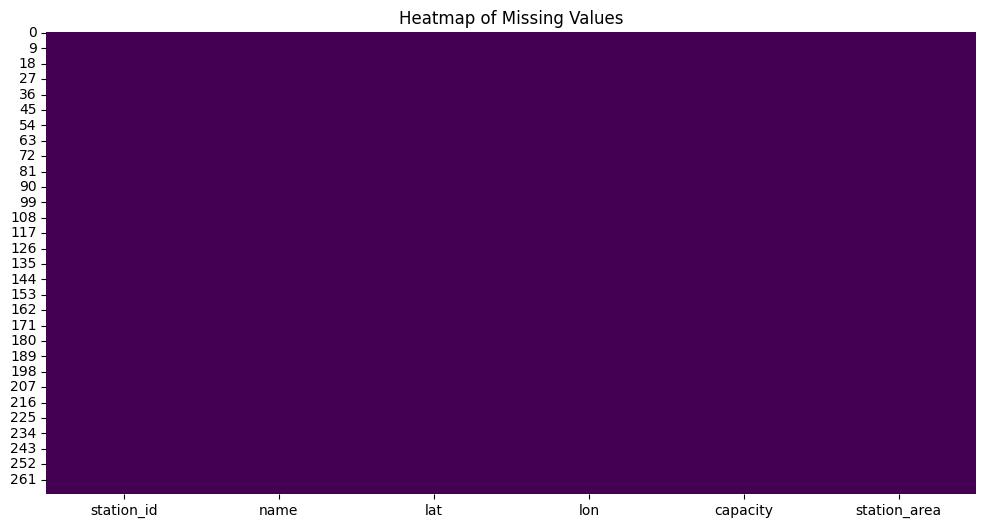

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Adjust size as needed
sns.heatmap(df_selected_stations_info.isna(), cbar=False, cmap='viridis')  # or cmap='coolwarm', 'magma', etc.
plt.title("Heatmap of Missing Values")
plt.show()
#I checked hier both isna() und isnull()

In [83]:
#zusammenführung beide dataframe anhand station_id
df_merged_stations = pd.merge(df_selected_stations_info, df_status_kept, on='station_id', how='inner')

In [84]:
df_merged_stations

,station_id,name,lat,lon,capacity,station_area,is_installed,is_renting,is_returning,num_docks_available
0,5431,NRK,59.933350,10.719603,21,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,19
1,5424,Makrellbekken T,59.941903,10.674101,18,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,18
2,5220,Blindern vgs,59.949909,10.730185,20,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,20
3,5217,Egertorget,59.912674,10.742025,30,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,1
4,5113,Leirfallsgata,59.919115,10.757831,15,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,15
...,...,...,...,...,...,...,...,...,...,...
265,377,Tøyenparken,59.915667,10.777567,29,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,19
266,738,Lodalen busstopp,59.903453,10.777958,12,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,11
267,460,Botanisk Hage sør,59.915418,10.769330,29,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,29
268,744,Hallénparken,59.931530,10.762169,10,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,10


In [85]:
df_merged_stations.columns

Index(['station_id', 'name', 'lat', 'lon', 'capacity', 'station_area',
       'is_installed', 'is_renting', 'is_returning', 'num_docks_available'],
      dtype='object')

In [86]:
# we can check if the extraction is correct : capacity should be bigger than num_docks_available
# es ist richtig
df_merged_stations[df_merged_stations['capacity'] < df_merged_stations['num_docks_available'] ]

,station_id,name,lat,lon,capacity,station_area,is_installed,is_renting,is_returning,num_docks_available


In [87]:
df_status

,station_id,is_installed,is_renting,is_returning,last_reported,num_vehicles_available,num_bikes_available,num_docks_available,vehicle_types_available,last_reported_dt,bike,ebike
0,5431,True,True,True,1749111367,2,2,19,"[{'vehicle_type_id': 'bike', 'count': 2}, {'ve...",2025-06-05 08:16:07,2,0
1,5424,True,True,True,1749111367,0,0,18,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07,0,0
2,5220,True,True,True,1749111367,0,0,20,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07,0,0
3,5217,True,True,True,1749111367,29,29,1,"[{'vehicle_type_id': 'bike', 'count': 29}, {'v...",2025-06-05 08:16:07,29,0
4,5113,True,True,True,1749111367,0,0,15,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,377,True,True,True,1749111367,9,9,19,"[{'vehicle_type_id': 'bike', 'count': 7}, {'ve...",2025-06-05 08:16:07,7,2
266,738,True,True,True,1749111367,1,1,11,"[{'vehicle_type_id': 'bike', 'count': 1}, {'ve...",2025-06-05 08:16:07,1,0
267,460,True,True,True,1749111367,0,0,29,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07,0,0
268,744,True,True,True,1749111367,0,0,10,"[{'vehicle_type_id': 'bike', 'count': 0}, {'ve...",2025-06-05 08:16:07,0,0


In [88]:
df_history = df_status[["station_id", "bike", "ebike", "last_reported_dt"]]
df_history.rename(columns={'bike': 'num_bike','ebike':'num_ebike'}, inplace=True)
df_history

C:\Users\user\AppData\Local\Temp\ipykernel_20348\1146452212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_history.rename(columns={'bike': 'num_bike','ebike':'num_ebike'}, inplace=True)


,station_id,num_bike,num_ebike,last_reported_dt
0,5431,2,0,2025-06-05 08:16:07
1,5424,0,0,2025-06-05 08:16:07
2,5220,0,0,2025-06-05 08:16:07
3,5217,29,0,2025-06-05 08:16:07
4,5113,0,0,2025-06-05 08:16:07
...,...,...,...,...
265,377,7,2,2025-06-05 08:16:07
266,738,1,0,2025-06-05 08:16:07
267,460,0,0,2025-06-05 08:16:07
268,744,0,0,2025-06-05 08:16:07


In [89]:
#Reflection: the informations stored in the database for the every 10 seconds maybe with NoSql database is better 

In [91]:
df_stations['station_area'].apply(str).nunique() # so we are sure that the polygon are nque so we can keep it as a column in the station, the type would be spatial type

270

In [95]:
df_merged_stations.head()

,station_id,name,lat,lon,capacity,station_area,is_installed,is_renting,is_returning,num_docks_available
0,5431,NRK,59.933350,10.719603,21,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,19
1,5424,Makrellbekken T,59.941903,10.674101,18,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,18
2,5220,Blindern vgs,59.949909,10.730185,20,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,20
3,5217,Egertorget,59.912674,10.742025,30,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,1
4,5113,Leirfallsgata,59.919115,10.757831,15,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",True,True,True,15


In [ ]:

df_history.head()

,station_id,num_bike,num_ebike,last_reported_dt
0,5431,2,0,2025-06-05 08:16:07
1,5424,0,0,2025-06-05 08:16:07
2,5220,0,0,2025-06-05 08:16:07
3,5217,29,0,2025-06-05 08:16:07
4,5113,0,0,2025-06-05 08:16:07


In [ ]:
#the type of this column is Multipolygon in MongoDb, can support GeoJSON
#mysql is not supporting geospatial data  aber PostgreSQL + PostGIS   or SQLLIte + SpatialLite
#MongoDB unterstützt GeoJson nativ  : WGS84-Koordinaten erlaubt (longitude, latitude, nicht umgekehrt!)

In [ ]:
# I asked if using MongoDB better that relatinal yes it is better also since it natively supporing geoJSON and we can keep the 2 collections : stations and history 
# but the problem not like relational database the use of the join is automatic : you do the join in application code (or via aggregation $lookup)  and this is the only disadvantage Nachteil